# Notebook1 Demo

## Import required libraries

In [1]:
# import all libraries and modules
import sys; import os
import pytraj as pt
from sklearn.decomposition import PCA
import numpy as np
import scipy
from scipy import spatial

# for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d import art3d

import warnings
warnings.filterwarnings("ignore")

## Import modules from BKit

In [2]:
from BKit.SmoothPath import BuildSmoothMeanPath
from BKit.Utils import LoadTrajs, SplitEvenOdd, PlotSelected
from BKit.InterpolateCurve import InterpolatePath
from BKit.ConstructMilestones3D import ConstructMilestones3D
from BKit.ConstructMilestones3D import SortFrames

## Set model parameters

In [20]:
dim = 3         # pc dimention    
w_size = 550    # rolling ave window size, which is used as reference path
stride = w_size//5

ml_length = 4.0 # distance between milestones
dz = .8         # cutoff along normal to disk for selection of mls
dr = 12.0       # milestone radius (disk radius)
n_iter = 4000   # number of iterations for ML disk normal optimization
thresh = -0.27  # threshold to remove points with corners 
yz_pad = 25     # yz pad length to avoid disk distortion upon visualization

DIR_SAVE = '../output/'
FIG_SAVE = '../figs/'
complex_name = 'PL1'

## Set  path to all input files & load trajectories



In [21]:
path = '/home/talant/Projects/UCRiver/Milestoning/CDK8/PL1/data/'
TOP = path + 'protein.prmtop'
TRAJ = path + 'nowater1.dcd'
pdb_path = path + '0.pdb'
mask_align = "(:1-359)&(@N,@C,@CA,@O)" 
mask_selec = ['@CA,:620','!@H*'] # @CA,:620 -- all CA's and residue 620
                                 # !@H*     -- exclude all hydrogens 
new_frames, refframe, traj= LoadTrajs(traj_path = TRAJ,
                                    top_path = TOP,
                                    refPDB_path = pdb_path,
                                    mask_selec = mask_selec,
                                    mask_align = mask_align)


Total number of residues --  620
Total number of atoms --  10356
Total number of frames --  6000
Loading metadynamics trajectory by chunk... 


100%|██████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 24.57it/s]

Total number of selected atoms --  650


## Perform PCA

In [22]:
pca = PCA(n_components=dim)
PCs = pca.fit_transform(new_frames)
  
# obtain eigvals and eigvecs
eigvals = pca.explained_variance_ratio_
eigvecs = pca.components_.T
  
dat = np.concatenate((np.dot(new_frames, eigvecs[:,0]).reshape(len(new_frames),1),
                      np.dot(new_frames, eigvecs[:,1]).reshape(len(new_frames),1),
                      np.dot(new_frames, eigvecs[:,2]).reshape(len(new_frames),1)),
                      axis=1)
print('Coverage',round(sum(pca.explained_variance_ratio_)*100,1))

Coverage 81.5


## Visualize PCA Space

<IPython.core.display.Javascript object>


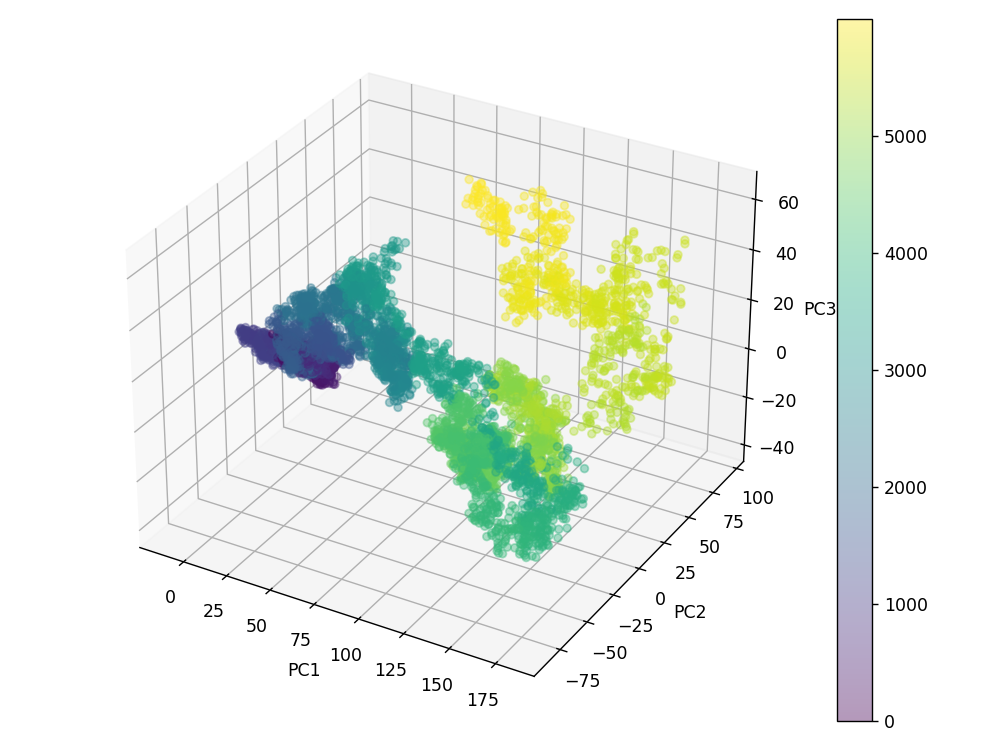

In [23]:
%matplotlib notebook
plotOrig = True

fig = plt.figure(figsize = [8, 6])
ax = plt.axes(projection='3d')
p = ax.scatter3D(dat[:,0], dat[:,1], dat[:,2], c=range(int(len(dat))), alpha=0.4)
fig.colorbar(p, ax=ax)
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
fig.tight_layout()
plt.savefig(FIG_SAVE + complex_name + '3D_PCA.png')

## Construct 3D Path

In [24]:
#this constructs 3D path
SReactPath = BuildSmoothMeanPath(dat, w_size=w_size, thresh=thresh, stride=stride)    
meanP = SReactPath.GetPath()

# crude path to compare
CrudePath = SReactPath.roll_ave(w_size=w_size//2, stride=stride//2)
kd_path = SReactPath.GetPathKD(rad=dr, w_size=w_size, stride=stride)

#interpolate  points  
InterPath = InterpolatePath(meanP, pair_dist = ml_length , dim=dim, kind='linear')
InterPathKD = InterpolatePath(kd_path, pair_dist = ml_length , dim=dim, kind='linear')

## Visualize crude path vs constructed smooth path

<IPython.core.display.Javascript object>


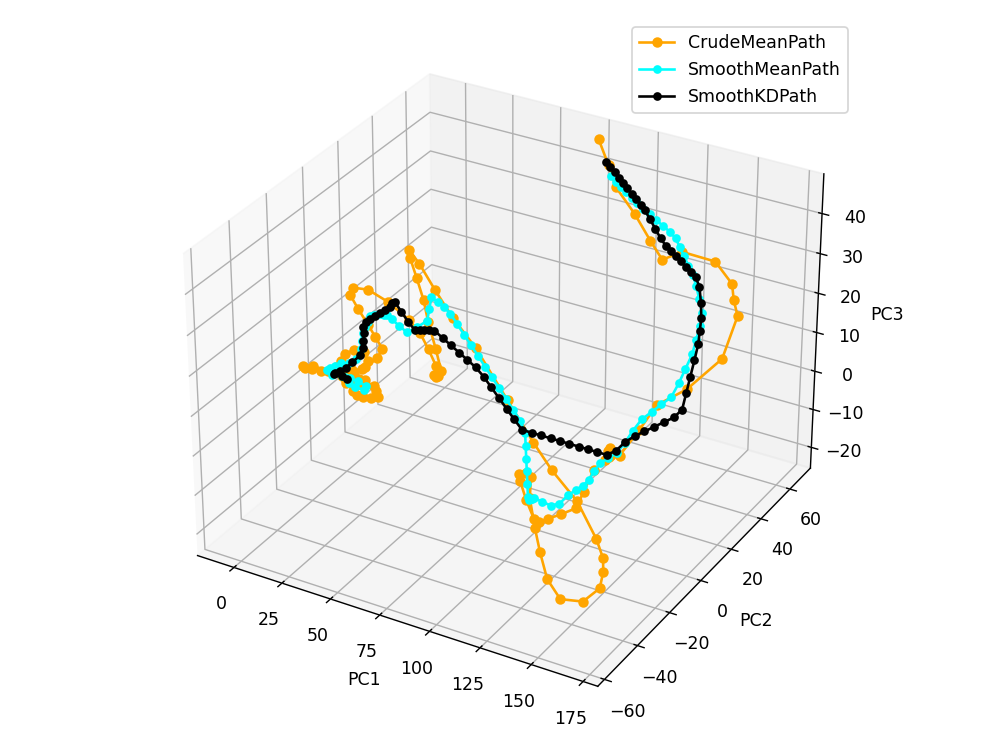

In [25]:
%matplotlib notebook
plotOrig = False

fig = plt.figure(figsize = [8, 6])
ax = plt.axes(projection='3d')

if plotOrig:
    p = ax.scatter3D(dat[:,0], dat[:,1], dat[:,2], c=range(int(len(dat))), alpha=0.4)
    fig.colorbar(p, ax=ax)

ax.plot3D(CrudePath[:,0], CrudePath[:,1], CrudePath[:,2], 'orange', marker='o', markersize=5)
ax.plot3D(InterPath[:,0], InterPath[:,1], InterPath[:,2], 'cyan', ls='-', marker='o', markersize=4)
ax.plot3D(InterPathKD[:,0], InterPathKD[:,1], InterPathKD[:,2], 'black', ls='-', marker='o', markersize=4)

ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
plt.legend(["CrudeMeanPath", "SmoothMeanPath", 'SmoothKDPath'])
fig.tight_layout()
plt.savefig(FIG_SAVE + complex_name + '3D_path.png')

## Now lets break into states with barriers

1. We use half length of ml


In [26]:
##################################################################################
# apply with equidistant partition of path using half ml_length
#pathAll = InterpolatePath(meanP, pair_dist=ml_length/2, dim=dim, kind='linear')
pathAll = InterpolatePath(kd_path, pair_dist=ml_length/2, dim=dim, kind='linear')

#pathAll = pathAll[10:-1] # drop 2 initial points

#split into barriers and states
diskID, midID = SplitEvenOdd(N=pathAll.shape[0])
pathMid = pathAll[midID]
pathP = pathAll[diskID]    

In [27]:
# construct 3D milestones (disks)
ConsMile = ConstructMilestones3D(pathAll)
vecs = ConsMile.GetVectors()
normalsAll = ConsMile.OptVectors(vecs, n_iter=n_iter, lr=0.01)

#split to state and barriers
normals = normalsAll[diskID]       # barrier disk vectors
normalsMid = normalsAll[midID]     # mid disk vectors

In [28]:
n_disks = normals.shape[0]        # also number of barriers
n_cells = normalsMid.shape[0]     # also number of states
print('Number of disks -- ', n_disks)
print('Number of cells -- ', n_cells)

Number of disks --  83
Number of cells --  82


## Extract points on disk surface

In [29]:
SortF = SortFrames(dat,dr,dz)
datDS, _ = SortF.SortAllPoints(normals, normalsMid, pathP, pathMid, SortMethod='surface')

<IPython.core.display.Javascript object>


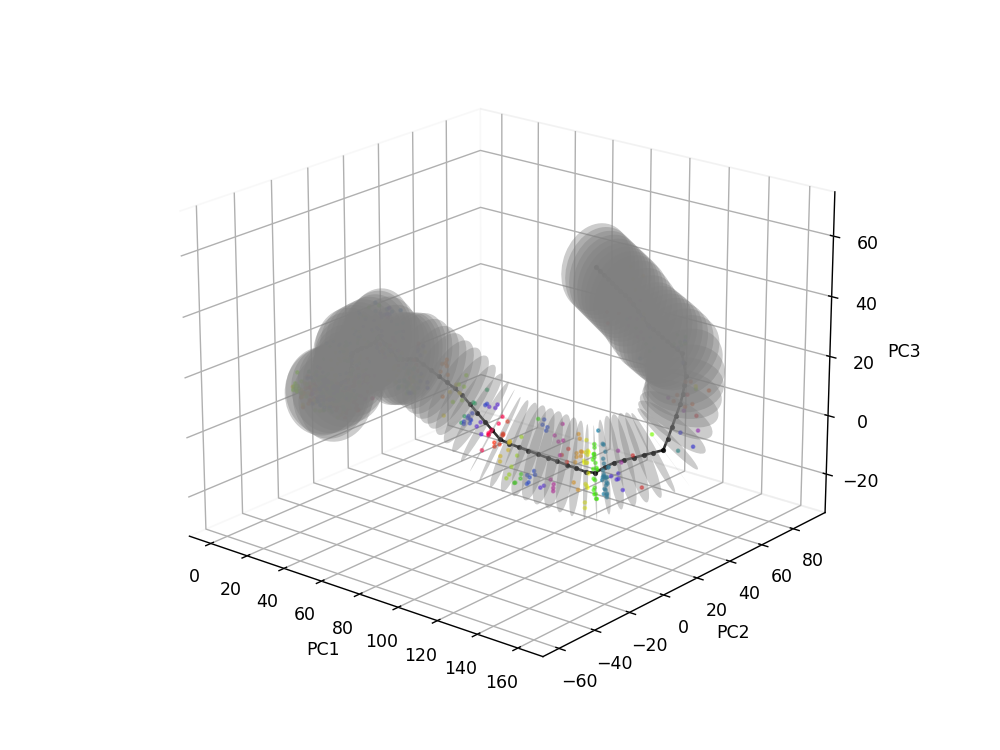

In [31]:
dr=15.0
PlotSelected(datDS, dr, pathP, normals, yz_pad,figsize=[8,6])
if plotOrig:
    p = ax.scatter3D(dat[:,0], dat[:,1], dat[:,2], c = range(int(len(dat))), alpha=0.2)
    


### Select points between disks
1. This method is used to assign state index to each point and to carry kinetics calculation later

In [33]:
datMid, _ = SortF.SortAllPoints(normals, normalsMid, pathP, pathMid, SortMethod='middle')

<IPython.core.display.Javascript object>


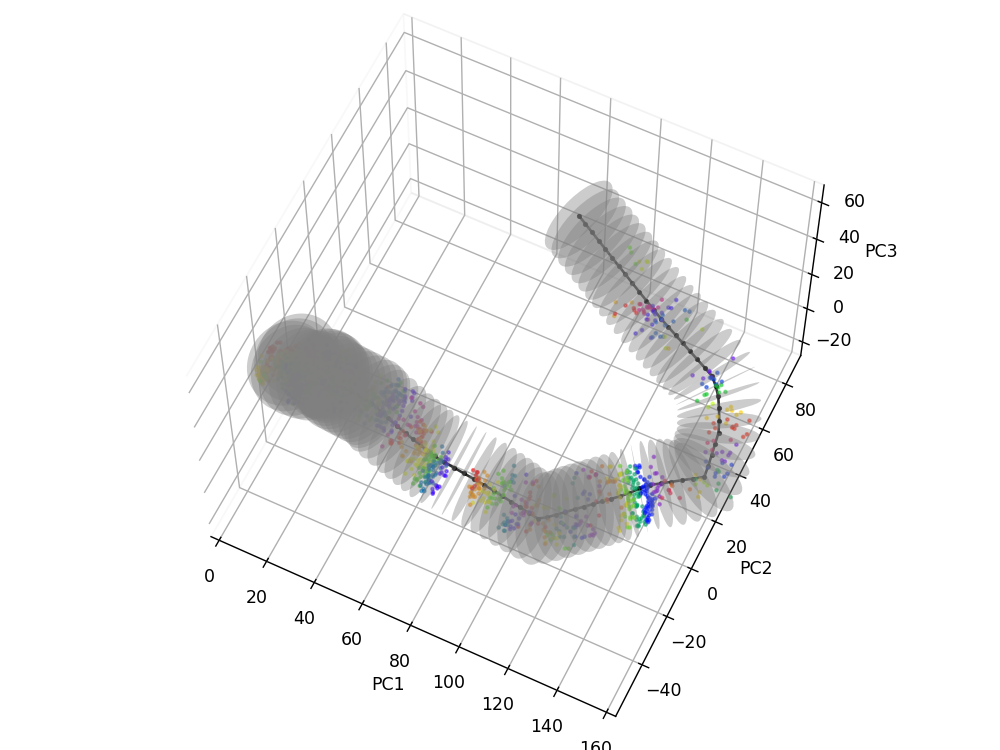

In [34]:
PlotSelected(datMid, dr, pathP, normals, yz_pad, figsize=[8,6])

In [20]:
print("writing outputs to " + DIR_SAVE)
np.save(DIR_SAVE + '/MlPosNorms.npy', np.column_stack([pathAll, normalsAll]))
np.save(DIR_SAVE + '/EigVecs.npy', eigvecs)
np.save(DIR_SAVE + '/RefFrame.npy', refframe)

writing outputs to ../output/


### Choose how to select points to initiate kinetics runs!

In [21]:
SortMethod = 'middle' # 'surface'
if SortMethod == 'middle':
    sel_frames = datMid[:,4]
elif SortMethod == 'surface':
    sel_frames = datDS[:,4]
else: 
    print('Make your own method :)')

sel_frames.shape

(1710,)

## Save selected frames as .dcd

In [33]:
#output trajs
pt.write_traj('output/SelectedFrames4ShortMD.dcd', traj[sel_frames], overwrite=True)

## Select frames on disks and save as .dcd

In [15]:
for i in range(n_disks):
    sel_frames = datDS[datDS[:,3]==i][:,4]
    if sel_frames.size != 0:
        pt.write_traj('output/OnDisk/UnbindIndx' + str(i) + '.dcd',
                      traj[sel_frames],
                      overwrite=True)
    else:
        print('Empty Disk ID', i)

Empty Disk ID 16
Empty Disk ID 17
Empty Disk ID 32
Empty Disk ID 57
Empty Disk ID 58
Empty Disk ID 66
Empty Disk ID 68
Empty Disk ID 69
Empty Disk ID 73
Empty Disk ID 76
Empty Disk ID 77
Empty Disk ID 78
Empty Disk ID 79
Empty Disk ID 80
Empty Disk ID 87
Empty Disk ID 88
Empty Disk ID 89
Empty Disk ID 90
Empty Disk ID 91


# Done!

In [ ]:
# Done!